# Mixed States Reconstruction (Infidelity as loss)

In [469]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [470]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation (Haar Distribution)

In [471]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [472]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [473]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [474]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand(3) * bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [475]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [476]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [477]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [478]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [479]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [480]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [481]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [482]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [483]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [484]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [498]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [499]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [500]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [502]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [503]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [533]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:800], bloch_vectors_with_noise[800:900], bloch_vectors_with_noise[900:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:800], bloch_vectors_noise_free[800:900], bloch_vectors_noise_free[900:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [534]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [535]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [566]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(32, activation='relu')(input_layer1)
#x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x)
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_171"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_172 (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 dense_182 (Dense)              (None, 32)           128         ['input_172[0][0]']              
                                                                                                  
 dense_183 (Dense)              (None, 16)           528         ['dense_182[0][0]']              
                                                                                                  
 vector (Dense)                 (None, 3)            51          ['dense_183[0][0]']              
                                                                                          

In [567]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00005)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=80, epochs=3000)

Epoch 1/3000
10/10 [==============================] - 2s 49ms/step - loss: 0.2284 - val_loss: 0.2372
Epoch 2/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.2269 - val_loss: 0.2354
Epoch 3/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.2253 - val_loss: 0.2336
Epoch 4/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.2238 - val_loss: 0.2317
Epoch 5/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.2221 - val_loss: 0.2297
Epoch 6/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.2203 - val_loss: 0.2278
Epoch 7/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.2184 - val_loss: 0.2257
Epoch 8/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.2165 - val_loss: 0.2233
Epoch 9/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.2143 - val_loss: 0.2208
Epoch 10/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.2121 - val_lo

10/10 [==============================] - 0s 14ms/step - loss: 0.0676 - val_loss: 0.0642
Epoch 82/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0669 - val_loss: 0.0633
Epoch 83/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0661 - val_loss: 0.0625
Epoch 84/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0654 - val_loss: 0.0618
Epoch 85/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0647 - val_loss: 0.0609
Epoch 86/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0639 - val_loss: 0.0602
Epoch 87/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0592
Epoch 88/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0585
Epoch 89/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0616 - val_loss: 0.0576
Epoch 90/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0608 - val_loss: 0

Epoch 161/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0314 - val_loss: 0.0305
Epoch 162/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0310 - val_loss: 0.0303
Epoch 163/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0307 - val_loss: 0.0302
Epoch 164/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0304 - val_loss: 0.0300
Epoch 165/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0300 - val_loss: 0.0298
Epoch 166/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0297 - val_loss: 0.0298
Epoch 167/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0296 - val_loss: 0.0298
Epoch 168/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0294 - val_loss: 0.0297
Epoch 169/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0290 - val_loss: 0.0294
Epoch 170/3000
10/10 [==============================] - 0s 12ms/step - lo

10/10 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0364
Epoch 241/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0311 - val_loss: 0.0364
Epoch 242/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0311 - val_loss: 0.0365
Epoch 243/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0312 - val_loss: 0.0365
Epoch 244/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0312 - val_loss: 0.0365
Epoch 245/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0313 - val_loss: 0.0367
Epoch 246/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0314 - val_loss: 0.0367
Epoch 247/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0314 - val_loss: 0.0366
Epoch 248/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0314 - val_loss: 0.0369
Epoch 249/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0316 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0342 - val_loss: 0.0386
Epoch 320/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0342 - val_loss: 0.0387
Epoch 321/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0343 - val_loss: 0.0386
Epoch 322/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0343 - val_loss: 0.0387
Epoch 323/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0343 - val_loss: 0.0387
Epoch 324/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0344 - val_loss: 0.0389
Epoch 325/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0344 - val_loss: 0.0388
Epoch 326/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0345 - val_loss: 0.0389
Epoch 327/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0346 - val_loss: 0.0389
Epoch 328/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0346 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0377 - val_loss: 0.0416
Epoch 399/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0377 - val_loss: 0.0417
Epoch 400/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0378 - val_loss: 0.0417
Epoch 401/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0378 - val_loss: 0.0416
Epoch 402/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0378 - val_loss: 0.0417
Epoch 403/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0378 - val_loss: 0.0417
Epoch 404/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0378 - val_loss: 0.0417
Epoch 405/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0379 - val_loss: 0.0417
Epoch 406/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0380 - val_loss: 0.0420
Epoch 407/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0380 - va

10/10 [==============================] - 0s 18ms/step - loss: 0.0395 - val_loss: 0.0435
Epoch 478/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0394 - val_loss: 0.0436
Epoch 479/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0395 - val_loss: 0.0439
Epoch 480/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0396 - val_loss: 0.0438
Epoch 481/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0396 - val_loss: 0.0439
Epoch 482/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0396 - val_loss: 0.0438
Epoch 483/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0396 - val_loss: 0.0439
Epoch 484/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0397 - val_loss: 0.0440
Epoch 485/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0397 - val_loss: 0.0438
Epoch 486/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0396 - va

10/10 [==============================] - 0s 11ms/step - loss: 0.0407 - val_loss: 0.0447
Epoch 557/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0407 - val_loss: 0.0448
Epoch 558/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0408 - val_loss: 0.0448
Epoch 559/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0407 - val_loss: 0.0447
Epoch 560/3000
10/10 [==============================] - 0s 17ms/step - loss: 0.0410 - val_loss: 0.0450
Epoch 561/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0410 - val_loss: 0.0451
Epoch 562/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0409 - val_loss: 0.0448
Epoch 563/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0409 - val_loss: 0.0447
Epoch 564/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0409 - val_loss: 0.0448
Epoch 565/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0409 - va

10/10 [==============================] - 0s 11ms/step - loss: 0.0419 - val_loss: 0.0453
Epoch 636/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0418 - val_loss: 0.0452
Epoch 637/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0419 - val_loss: 0.0453
Epoch 638/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0452
Epoch 639/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0418 - val_loss: 0.0453
Epoch 640/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0454
Epoch 641/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0419 - val_loss: 0.0452
Epoch 642/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0452
Epoch 643/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0418 - val_loss: 0.0450
Epoch 644/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0419 - va

10/10 [==============================] - 0s 14ms/step - loss: 0.0423 - val_loss: 0.0450
Epoch 715/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0423 - val_loss: 0.0448
Epoch 716/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0422 - val_loss: 0.0449
Epoch 717/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0423 - val_loss: 0.0450
Epoch 718/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0423 - val_loss: 0.0449
Epoch 719/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0423 - val_loss: 0.0449
Epoch 720/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0424 - val_loss: 0.0451
Epoch 721/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0423 - val_loss: 0.0449
Epoch 722/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0423 - val_loss: 0.0448
Epoch 723/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0423 - va

10/10 [==============================] - 0s 12ms/step - loss: 0.0429 - val_loss: 0.0445
Epoch 794/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0429 - val_loss: 0.0446
Epoch 795/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0430 - val_loss: 0.0450
Epoch 796/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0430 - val_loss: 0.0446
Epoch 797/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0430 - val_loss: 0.0448
Epoch 798/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0429 - val_loss: 0.0446
Epoch 799/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0428 - val_loss: 0.0447
Epoch 800/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0430 - val_loss: 0.0447
Epoch 801/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0430 - val_loss: 0.0448
Epoch 802/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0429 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0445
Epoch 873/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0433 - val_loss: 0.0444
Epoch 874/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0436 - val_loss: 0.0447
Epoch 875/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0434 - val_loss: 0.0443
Epoch 876/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0434 - val_loss: 0.0446
Epoch 877/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0436 - val_loss: 0.0446
Epoch 878/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0434 - val_loss: 0.0444
Epoch 879/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0434 - val_loss: 0.0445
Epoch 880/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0435 - val_loss: 0.0445
Epoch 881/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0435 - va

10/10 [==============================] - 0s 13ms/step - loss: 0.0440 - val_loss: 0.0445
Epoch 952/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0438 - val_loss: 0.0443
Epoch 953/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0438 - val_loss: 0.0446
Epoch 954/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0439 - val_loss: 0.0445
Epoch 955/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0438 - val_loss: 0.0444
Epoch 956/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0439 - val_loss: 0.0445
Epoch 957/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0439 - val_loss: 0.0445
Epoch 958/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0440 - val_loss: 0.0445
Epoch 959/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0439 - val_loss: 0.0446
Epoch 960/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0438 - va

10/10 [==============================] - 0s 11ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1031/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 1032/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 1033/3000
10/10 [==============================] - 0s 17ms/step - loss: 0.0443 - val_loss: 0.0448
Epoch 1034/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0440 - val_loss: 0.0443
Epoch 1035/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0441 - val_loss: 0.0446
Epoch 1036/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1037/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0439 - val_loss: 0.0444
Epoch 1038/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0442 - val_loss: 0.0448
Epoch 1039/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.

Epoch 1109/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0441 - val_loss: 0.0445
Epoch 1110/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0443 - val_loss: 0.0450
Epoch 1111/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0444
Epoch 1112/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0441 - val_loss: 0.0447
Epoch 1113/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 1114/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1115/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 1116/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 1117/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0441 - val_loss: 0.0446
Epoch 1118/3000
10/10 [==============================] - 0s 16ms

Epoch 1188/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 1189/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1190/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.0449
Epoch 1191/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 1192/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1193/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1194/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0448
Epoch 1195/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.0447
Epoch 1196/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0443 - val_loss: 0.0446
Epoch 1197/3000
10/10 [==============================] - 0s 11ms

Epoch 1267/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 1268/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1269/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 1270/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 1271/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0444
Epoch 1272/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0449
Epoch 1273/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0443 - val_loss: 0.0443
Epoch 1274/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0441 - val_loss: 0.0445
Epoch 1275/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0442 - val_loss: 0.0445
Epoch 1276/3000
10/10 [==============================] - 0s 12ms

Epoch 1346/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0443 - val_loss: 0.0443
Epoch 1347/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 1348/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 1349/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.0446
Epoch 1350/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0442 - val_loss: 0.0445
Epoch 1351/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 1352/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1353/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 1354/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1355/3000
10/10 [==============================] - 0s 16ms

Epoch 1425/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 1426/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 1427/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 1428/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0448
Epoch 1429/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0446
Epoch 1430/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0443 - val_loss: 0.0445
Epoch 1431/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0446
Epoch 1432/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 1433/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1434/3000
10/10 [==============================] - 0s 15ms

Epoch 1504/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 1505/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0447
Epoch 1506/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 1507/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0447
Epoch 1508/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 1509/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1510/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.0446
Epoch 1511/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0445
Epoch 1512/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0446
Epoch 1513/3000
10/10 [==============================] - 0s 14ms

Epoch 1583/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0445
Epoch 1584/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1585/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0444 - val_loss: 0.0446
Epoch 1586/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 1587/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0447
Epoch 1588/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 1589/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 1590/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 1591/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0444 - val_loss: 0.0445
Epoch 1592/3000
10/10 [==============================] - 0s 16ms

Epoch 1662/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0442
Epoch 1663/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0444 - val_loss: 0.0446
Epoch 1664/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 1665/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 1666/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1667/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 1668/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0442 - val_loss: 0.0443
Epoch 1669/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 1670/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0445
Epoch 1671/3000
10/10 [==============================] - 0s 15ms

Epoch 1741/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 1742/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 1743/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0444 - val_loss: 0.0443
Epoch 1744/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 1745/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0444 - val_loss: 0.0442
Epoch 1746/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 1747/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0440
Epoch 1748/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 1749/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 1750/3000
10/10 [==============================] - 0s 12ms

Epoch 1820/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0442
Epoch 1821/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0445 - val_loss: 0.0439
Epoch 1822/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 1823/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 1824/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0443
Epoch 1825/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 1826/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 1827/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 1828/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 1829/3000
10/10 [==============================] - 0s 11ms

Epoch 1899/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 1900/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 1901/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 1902/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 1903/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0440
Epoch 1904/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 1905/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0448 - val_loss: 0.0441
Epoch 1906/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 1907/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 1908/3000
10/10 [==============================] - 0s 16ms

Epoch 1978/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0439
Epoch 1979/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0441
Epoch 1980/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 1981/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0441
Epoch 1982/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0440
Epoch 1983/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 1984/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 1985/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0440
Epoch 1986/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0439
Epoch 1987/3000
10/10 [==============================] - 0s 16ms

Epoch 2057/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0440
Epoch 2058/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 2059/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2060/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2061/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0440
Epoch 2062/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0440
Epoch 2063/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2064/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0440
Epoch 2065/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0439
Epoch 2066/3000
10/10 [==============================] - 0s 13ms

Epoch 2136/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2137/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0447 - val_loss: 0.0438
Epoch 2138/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2139/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2140/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2141/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2142/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0449 - val_loss: 0.0438
Epoch 2143/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0444 - val_loss: 0.0441
Epoch 2144/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2145/3000
10/10 [==============================] - 0s 15ms

Epoch 2215/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0437
Epoch 2216/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0443
Epoch 2217/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0440
Epoch 2218/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 2219/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2220/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0445 - val_loss: 0.0440
Epoch 2221/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 2222/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2223/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 2224/3000
10/10 [==============================] - 0s 15ms

Epoch 2294/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 2295/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2296/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 2297/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0447 - val_loss: 0.0437
Epoch 2298/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0445 - val_loss: 0.0442
Epoch 2299/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2300/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 2301/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 2302/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0438
Epoch 2303/3000
10/10 [==============================] - 0s 13ms

Epoch 2373/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0441
Epoch 2374/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 2375/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0450 - val_loss: 0.0440
Epoch 2376/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0443 - val_loss: 0.0438
Epoch 2377/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0449 - val_loss: 0.0445
Epoch 2378/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0437
Epoch 2379/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 2380/3000
10/10 [==============================] - 0s 16ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2381/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 2382/3000
10/10 [==============================] - 0s 15ms

Epoch 2452/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2453/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0449 - val_loss: 0.0439
Epoch 2454/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2455/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0439
Epoch 2456/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0446 - val_loss: 0.0441
Epoch 2457/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0446 - val_loss: 0.0437
Epoch 2458/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 2459/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2460/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2461/3000
10/10 [==============================] - 0s 12ms

Epoch 2531/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.0438
Epoch 2532/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0448 - val_loss: 0.0440
Epoch 2533/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0447 - val_loss: 0.0440
Epoch 2534/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0449 - val_loss: 0.0438
Epoch 2535/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0440
Epoch 2536/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2537/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2538/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2539/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0437
Epoch 2540/3000
10/10 [==============================] - 0s 12ms

Epoch 2610/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0448 - val_loss: 0.0441
Epoch 2611/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0436
Epoch 2612/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0445 - val_loss: 0.0438
Epoch 2613/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0449 - val_loss: 0.0437
Epoch 2614/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 2615/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2616/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0437
Epoch 2617/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 2618/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.0440
Epoch 2619/3000
10/10 [==============================] - 0s 12ms

Epoch 2689/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2690/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2691/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0440
Epoch 2692/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2693/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.0439
Epoch 2694/3000
10/10 [==============================] - 0s 17ms/step - loss: 0.0447 - val_loss: 0.0436
Epoch 2695/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2696/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0450 - val_loss: 0.0438
Epoch 2697/3000
10/10 [==============================] - 0s 11ms/step - loss: 0.0449 - val_loss: 0.0442
Epoch 2698/3000
10/10 [==============================] - 0s 13ms

Epoch 2768/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0440
Epoch 2769/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2770/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0437
Epoch 2771/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 2772/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.0440
Epoch 2773/3000
10/10 [==============================] - 0s 17ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2774/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2775/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0451 - val_loss: 0.0436
Epoch 2776/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 2777/3000
10/10 [==============================] - 0s 15ms

Epoch 2847/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0437
Epoch 2848/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2849/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2850/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 2851/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0448 - val_loss: 0.0443
Epoch 2852/3000
10/10 [==============================] - 0s 14ms/step - loss: 0.0450 - val_loss: 0.0439
Epoch 2853/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0438
Epoch 2854/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0449 - val_loss: 0.0439
Epoch 2855/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0439
Epoch 2856/3000
10/10 [==============================] - 0s 12ms

Epoch 2926/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0443
Epoch 2927/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0450 - val_loss: 0.0433
Epoch 2928/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 2929/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0448 - val_loss: 0.0434
Epoch 2930/3000
10/10 [==============================] - 0s 12ms/step - loss: 0.0446 - val_loss: 0.0442
Epoch 2931/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0451 - val_loss: 0.0438
Epoch 2932/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0445 - val_loss: 0.0439
Epoch 2933/3000
10/10 [==============================] - 0s 13ms/step - loss: 0.0450 - val_loss: 0.0440
Epoch 2934/3000
10/10 [==============================] - 0s 15ms/step - loss: 0.0450 - val_loss: 0.0438
Epoch 2935/3000
10/10 [==============================] - 0s 15ms

In [568]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

4/4 - 0s - loss: 0.0421 - 305ms/epoch - 76ms/step


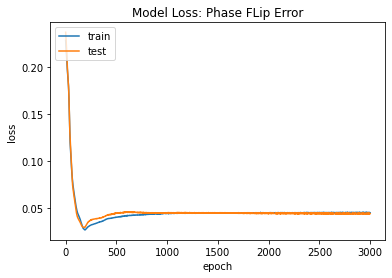

In [569]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [570]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.957862459745879-3.55995587217525e-09j), shape=(), dtype=complex128)
